<h1><center>Final Assignement</center></h1>

Student number: 200420653

<a class="anchor" id="0"></a>
## Table of content
1. [Introduction and objectives](#1)<br>
    1.1 [Introduction](#1.1)<br>

2. [Data](#2)<br>
    2.1 [Data sources](#2.1)<br>
    2.2 [Data cleaning](#2.2)<br>
    2.3 [Data preparation](#2.3)<br>

4. [Summary](#4)<br>

**Doings:** 
<br>

Code
- merge df with weekdays
- only read in data in dataframes that is needed. In case something not needed, delete it
-create classes; use special skills like the super class or an inheritance from another class; ask gpt which special skills could make sense
- If I reduce the size of the df and hash the values to integers the question remains if the models predictions would have been better without that conversion + check if float32 conversion decreases accuracy of models
- Use scalene to measure the performance of the code
- clarify how the 7 step approach from chollet book is used
- dataframe: hash id's to decrease size of df drastically. Could speed up all computations
- maybe normalization makes sense but beware of fact that only reading operations are done on the data
- it seems like I have use tensorflow, so keep in mind that it is used somewhere. Maybe just keras works

Report
- correct citation style with ACM and Mendeley

In [1]:
#Import data handling libraries
import pandas as pd
import dask.dataframe as dd
import numpy as np

In [2]:
#Specify directories

###local###
#get parent folder of current directory
parent_dir = '/Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction'
print('Parent directory of current notebook: ' + parent_dir)

#Directory resources
res_dir = parent_dir + '/res/'
print('Resource directory: ' + res_dir)


###On Kaggle###
#res_dir = '/kaggle/input/m5-forecasting-accuracy/'


print('Resource directory: ' + res_dir)

Parent directory of current notebook: /Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction
Resource directory: /Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction/res/
Resource directory: /Users/mf/Desktop/CS/Studies/7_Final_Project/Kaggle_M5PointPrediction/res/


In [3]:
#Import the provided csv files
df_cal = pd.read_csv(res_dir + 'calendar.csv')
df_prices = pd.read_csv(res_dir + 'sell_prices.csv')
df_train_eval = pd.read_csv(res_dir + 'sales_train_evaluation.csv')
#df_train_val = pd.read_csv(res_dir + 'sales_train_validation.csv')
#df_sample_subm = pd.read_csv(res_dir + 'sample_submission.csv')

In [4]:
#df_prices.head()

In [5]:
#df_train_eval.head()

In [6]:
#Inspect dataframes
# print('\nCalendar dataframe: ')
# print(df_cal.head())
# print('\nPrices dataframe: ')
# print(df_prices.head())
# print('\nTrain evaluation dataframe: ')
# print(df_train_eval.head())

In [7]:
#Helper function to reduce memory usage of dataframes
def reduce_df_mem_usage(df, df_name):
    """ 
    Helper function to iterate all columns of given dataframe and check and set for smallest dtype to reduce memory usage
    Taken and adapted from the widely used function which is available for instance here: 
    https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook
    There is a flaw in the integer section in the publicly available function which is that it possibly introduces rounding errors when converting to a smaller dtype
    """

    #Print original memory usage
    print('Dataframe ' + df_name + ' is being processed...')
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    #Iterate through each column
    for col in df.columns:
        #Get dtype
        col_type = df[col].dtype
        
        #try except throw block to try if the following code works, otherwise skip this loop
        try:

            #If type is not an object, therefore numerical, get biggest and smallest values
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                
                #If type is int
                if str(col_type)[:3] == 'int':
                    #If min value is greater than min value of given dtype and max value is smaller than max value of given dtype -> adjust dtype
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                #Downcasting of float values leads to rounding errors -> as precision is crucial for float values, no downcasting is performed

            #If none of the above, then assumption that  finite set of possible values -> convert to category which is internally stored as int but when queried returns the string
            else:
                df[col] = df[col].astype('category')
        
        except:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print('---------------------------------------------------\n')

    return df


# Reduce size for float when precision is not really needed
            # else:
                # if str(col_type)[:7] == 'float64':
                #     #calculate difference between original column and downcasted column
                #     diff_64_32 = np.abs(df[col] - df[col].astype(np.float32)).round(2)
                #     # If the max difference is below the threshold, downcast column
                #     if diff_64_32.max() < prec_threshold:
                #         diff_32_16 = np.abs(df[col] - df[col].astype(np.float16)).round(2)
                #         if diff_32_16.max() < prec_threshold:
                #             df[col] = df[col].astype(np.float16).round(2)
                #         else: df[col] = df[col].astype(np.float32).round(2)

## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_df_mem_usage(df, df_name, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
#Read in all data used later on
df_prices = reduce_df_mem_usage(df_prices, 'df_prices')
df_cal = reduce_df_mem_usage(df_cal, 'df_cal')
df_train_eval = reduce_df_mem_usage(df_train_eval, 'df_train_eval')

#delete dataframe from memory or just don't read in
#del df_sample_subm
#get name of dataframe


Dataframe df_prices is being processed...
Memory usage of dataframe is 208.77 MB
Memory usage of dataframe after optimization is: 84.90 MB
Decreased by 59.3%
---------------------------------------------------

Dataframe df_cal is being processed...
Memory usage of dataframe is 0.21 MB
Memory usage of dataframe after optimization is: 0.19 MB
Decreased by 8.7%
---------------------------------------------------

Dataframe df_train_eval is being processed...
Memory usage of dataframe is 452.91 MB
Memory usage of dataframe after optimization is: 96.30 MB
Decreased by 78.7%
---------------------------------------------------



Convert from wide to long format of the training dataframe. Right now all sales days are in columns. We want them in rows for processing in ML / DL models.

In [9]:
###Attention: when using cat codes I need to make sure, that it matches the same cat codes as in the df_prices
# Convert from wide to long format
#df_train_val.drop(columns=['id'], inplace=True)
df_conv = pd.melt(df_train_eval,
                    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                    var_name='d', 
                    value_name='sales_amount')

#del df_train_eval
df_conv = reduce_df_mem_usage(df_conv, 'df_conv')

#Convert new date column to category!

# Encode categorical variables (example using label encoding)
#for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'date']:
#    df_conv[col] = df_conv[col].astype('category').cat.codes


Dataframe df_conv is being processed...
Memory usage of dataframe is 1017.24 MB
Memory usage of dataframe after optimization is: 678.68 MB
Decreased by 33.3%
---------------------------------------------------



Now we have the issue, that 0 values in the sales_amount column could mean that there were no sales, it could also mean that the sales start of the product was later and the product was just not available.
The sales start date can be infered from the price df. If there is no sales week for a product then that most likely means it wasn't available for sale.
I will first try to delete all rows from df_conv where there were no weeks available for from the price df. This will be done by adding the week information from prices through a left join. Then the week information is available to make a right join on the prices table and thereby filter out all rows where there was no sales week available (the product didn't exist yet).

The reason why I didn't convert float types is that they loose precision. That is absolutely crucial for sales prediction. That is why now the dataframe is too large for the merge operation in the following. Even 30GB RAM machines run out of memory on this computation as it require much more memory than the original ~680MB for df_conv and ~85MB for Prices. The solution for me is using DASK which handles operations on dataframes in smaller chunks.

In [10]:
# Convert Pandas df to Dask df
#ddf_conv = dd.from_pandas(df_conv, npartitions=100)
#ddf_prices = dd.from_pandas(df_prices[['store_id', 'item_id', 'wm_yr_wk']], npartitions=50)

# Perform the merge operation
#ddf_merged = ddf_conv.merge(ddf_prices, on=['store_id', 'item_id'], how='left')

# Compute the result back to a Pandas dataframe if needed
#df_merged = ddf_merged.compute()

In [11]:
# Perform the merge operation
#ddf_merged = ddf_conv.merge(ddf_prices, on=['store_id', 'item_id'], how='left')



In [12]:
# Compute the result back to a Pandas dataframe if needed
#df_merged = ddf_merged.compute()

In [13]:
#df_merged.head()

In [14]:
####### Cited from the 1st solution (exact citing) #######
## Merging by concat to not lose dtypes
def merge_by_concat_left(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [15]:
## Merging by concat to not lose dtypes
# def merge_by_concat_right(df1, df2, merge_on):
#     merged_gf = df2[merge_on]
#     merged_gf = merged_gf.merge(df1, on=merge_on, how='left')
#     new_columns = [col for col in list(merged_gf) if col not in merge_on]
#     df2 = pd.concat([df2, merged_gf[new_columns]], axis=1)
#     return df2

In [ ]:
#join column wm_yr_wk from df_prices to df_conv 
#Original where I loose dtypes
#df_conv = df_conv.merge(df_cal[['d', 'wm_yr_wk']], on=['d'], how='left')

df_conv = merge_by_concat_left(df_conv, df_cal[['d', 'wm_yr_wk']], ['d'])

In [17]:
df_conv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales_amount,wm_yr_wk
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101


Merge with the prices df to get the sales start date for each product. Then filter out all rows where there was no price available (the product didn't exist yet).

In [18]:
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 9 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             category
 7   sales_amount  int16   
 8   wm_yr_wk      int16   
dtypes: category(7), int16(2)
memory usage: 791.6 MB


In [19]:
df_conv = merge_by_concat_left(df_conv, df_prices, ['store_id', 'item_id', 'wm_yr_wk'])

In [26]:
# filter df_conv when sell_price is not NaN
df_conv = df_conv[df_conv['sell_price'].notna()]

In [28]:
df_conv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 7 to 59181089
Data columns (total 10 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   store_id      category
 5   state_id      category
 6   d             category
 7   sales_amount  int16   
 8   wm_yr_wk      int16   
 9   sell_price    float64 
dtypes: category(7), float64(1), int16(2)
memory usage: 1.3 GB


In [ ]:
# Convert to categorical and then to integer codes
#df_prices['store_id'] = df_prices['store_id'].astype('category').cat.codes
#df_prices['item_id'] = df_prices['item_id'].astype('category').cat.codes
#df_prices['wm_yr_wk'] = df_prices['wm_yr_wk'].astype('category').cat.codes

# Optionally, store the mappings
#store_id_mapping = dict(enumerate(df_prices['store_id'].cat.categories))
#item_id_mapping = dict(enumerate(df_prices['item_id'].cat.categories))
#wm_yr_wk_mapping = dict(enumerate(df_prices['wm_yr_wk'].cat.categories))

In [ ]:
#Visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_long.head()
#unique values for column date
#df_long['date'].unique()

In [ ]:
#Import machine learning libraries
import tensorflow as tf
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

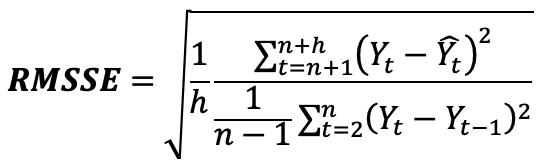

where Y_t is the actual future value of the examined time series at point t, (Y_t ) ̂ the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 

Note that the denominator of RMSSE is computed only for the time-periods for which the examined product(s) are actively sold, i.e., the periods following the first non-zero demand observed for the series under evaluation.   


In [ ]:
# Splitting the data
X = df_long.drop('sales_amount', axis=1)
y = df_long['sales_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the LightGBM model
lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lgbm_model.predict(X_test)

# Compute the denominator for RMSSE
historical_sales_diff = np.diff(y_train.sort_values())  # Make sure the sales are sorted by day
denominator = np.mean(np.square(historical_sales_diff))

# Compute the numerator for RMSSE
numerator = np.sum(np.square(y_test - y_pred))

# Calculate h, the number of forecasted points
h = len(y_test)

# Calculate RMSSE
rmsse = np.sqrt((1/h) * (numerator / denominator))

print('RMSSE:', rmsse)